# Random Graphs Impact Analysis

This notebook analyzes the impact of removing the highest-degree node from different types of random graphs on various centrality metrics.

In [1]:
# SETUP: workaround to avoid ipynb import errors
import os
import sys

candidate_roots = [
    os.getcwd(),
    os.path.dirname(os.getcwd()),
    os.path.dirname(os.path.dirname(os.getcwd())),
]
for root in candidate_roots:
    src_dir = os.path.join(root, "src")
    if os.path.isdir(src_dir) and src_dir not in sys.path:
        sys.path.append(src_dir)
        break

In [2]:
import networkx as nx

# define centrality metrics for the analysis
centrality_functions = {
    "degree": nx.degree_centrality,
    "betweenness": nx.betweenness_centrality,
    #"closeness": nx.closeness_centrality,
    #"eigenvector": lambda G: nx.eigenvector_centrality(G, max_iter=5000),
    # Use numpy variant to avoid error on larger graphs,TODO: results are weird, need to check later
    #"katz": lambda G: nx.katz_centrality_numpy(G, alpha=0.01, beta=1.0),
}

# define graph sizes
sizes = [
    #10,
    100,
    #1000
]

# define graph types
graph_types = [
    #"erdos_renyi", 
    "barabasi_albert", 
    #"watts_strogatz"
]

In [3]:
from application.graph_build_utlis import make_graph, highest_degree_node
from application.node_removal_graph_analyser import get_node_removal_impact

# compute the differences in centrality
results = []
for size in sizes:
    for gtype in graph_types:
        G = make_graph(gtype, size, True, True)
        node = highest_degree_node(G)

        for metric_name, metric_fn in centrality_functions.items():
            # TODO: add try catch to avoid plotting calculated errors, likely happening on katz
            elapsed, impact, _ = get_node_removal_impact(G, [node], metric_fn)
            results.append({
                "label": f"{gtype}-{size}-{metric_name}",
                "impact": impact,
                "graph": G,
                "gtype": gtype,
                "removed_nodes": [node]
            })


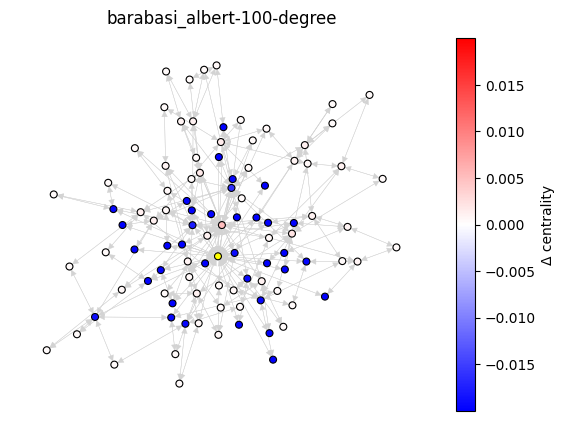

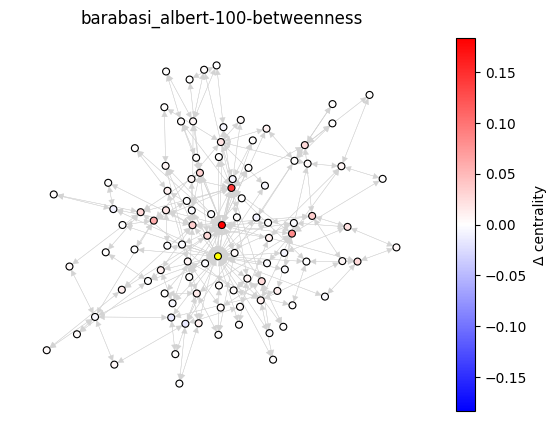

In [4]:
import numpy 
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from application.graph_plot import plot_result

pos_cache = {}
save_plots = False

for r in results:
    plot_result(r, pos_cache, save_plots)
